# Building your own maze-solving AI agent in Python

Reinforcement learning (RL) is a subfield of machine learning/AI in which an agent acts in an environment and learns to maximise the total reward it receives. Think a video game player agent learning to maximise its score in [Atari games](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning/), or an autonamous [helicopter learning to do aerial manuevres for rewards](https://www.youtube.com/watch?v=VCdxqn0fcnE), or a humanoid robot learning how to best [adjust its limb positions and joint torques to stand up](https://gym.openai.com/envs/HumanoidStandup-v1)(sort of..). In this post, we want to make a reinforcement learning agent that can learn to escape a grid-like environment while maximising rewards. Specifically, there is a worm that needs to get out of a maze as quickly as possible:

![Basic maze](basic_maze.png)

This is a pretty tame maze (nothing really on it - just +100 reward for getting to the end, and -1 everywhere else), so let's also make an advanced maze surrounded with dragon-filled lava (-100 reward, not good), a couple of perfectly-spherical trolls (-20 reward) and a treat (+20 reward, maybe a sugar cube... what do worms eat again?).

![Advanced maze](advanced_maze.png)

We'll use basic Python (+numpy/pandas) to allow the worm to learn how 'good' each state and action is - this goodness is represented by the values in the heatmap below. In this post, you'll see that the major trick is that these values incorporate information about potential future rewards leading on from that state. This means that once the agent knows these values (called Q values - we'll discuss), it can then make greedy decisions that maximise this value at each time step. This lets us solve simple grid worlds of different varieties, and we can then plot our trajectory within the grid world/maze.  

<img src="https://raw.githubusercontent.com/jagex-data-science/maze_runner/master/traversal_in_10_steps_random_p0.0.gif")>

![Traversal](https://raw.githubusercontent.com/jagex-data-science/maze_runner/master/traversal_in_10_steps_random_p0.0.gif)

![random](https://media.giphy.com/media/XOF6spgWpYXpm/giphy.gif)

If you just want the code to play around with, check out [this notebook](https://github.com/jagex-data-science/maze_runner/blob/master/maze_post_to_proofread.ipynb). The rest of the post will go through what the code is doing. Once everything is in place, we'll do some experiments to see how changes to parameters (learning rate, exploration/exploitation trade-offs, number of episodes, episode length, on-policy/off-policy method) affect our learning. 

## The maze problem

First let's introduce some language for talking about RL problems, and then get into the code.

RL deals with sequential environments indexed by time points. We say that at any time point the worm can be in any number of ***states*** (the different squares on the grid) and can take various ***actions*** from each state (here, our action space is [left, right, up and down] - but in some spots, like corner states, not all actions are available). Each state is associated with a ***reward*** $r$ - this is just a number, and is a property of the environment. So, we can make decisions about which action $a$ to take in a given state $s$ at time point $t$, and the environment gives a reward $r$ and puts us in a ***successor state*** $s'$. Each episode ends when the worm gets to ***terminal state*** - the end of the maze. Then it is (cruelly) transported back to the beginning where it has to start again. Let's say there's no dying/respawning, so if you get in lava you're punished severely (-100 reward) but you can still crawl out. 

### Rewards

Let's start setting up the environment. We need a reward matrix. For the simple maze, the numpy reward matrix looks like this:

In [14]:
# # imports first
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import random
# %matplotlib inline
# sns.set(font="monospace")
# random.seed(42)

# # for making GIFs
# import matplotlib.patches as patches
# import glob
# import imageio
# from natsort import natsorted

# basic maze state rewards
reward_matrix = np.array([[-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, 100]])

In the complicated maze, we've added a few other rewards. The numpy version is: 

In [15]:
# advanced maze state rewards
reward_matrix = np.array([[-1,  -1, -1,  -1,  -1,  -1],
                          [-1, -20, -1,  20,  -1,  -1],
                          [-1,  -1, -1,  -1,  -1,  -1],
                          [-1,  -1, -1,  -1, -20,  -1],
                          [-1,  -1, -1,  -1,  -1,  -1],
                          [-1,  -1, -1,  -1,  -1, 100]]).astype("float32")

reward_matrix = np.pad(reward_matrix, pad_width=1, mode='constant', constant_values=-100)
reward_matrix

array([[-100., -100., -100., -100., -100., -100., -100., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1., -100.],
       [-100.,   -1.,  -20.,   -1.,   20.,   -1.,   -1., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,  -20.,   -1., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,  100., -100.],
       [-100., -100., -100., -100., -100., -100., -100., -100.]], dtype=float32)

Let's just stick to this more interesting matrix for now. 

The worm can go through the maze using four actions - up, down, left or right: 

In [5]:
actions = np.array(['up', 'down', 'left', 'right'])

And it's easy to see how these actions change your position in grid world.

In [6]:
def move(current_state, action):
    
    next_state_x = current_state[0]
    next_state_y = current_state[1]
    
    if action=='up':
        next_state_x -=1
    elif action=='down':
        next_state_x +=1
    elif action=='left':
        next_state_y -=1
    elif action=='right':
        next_state_y +=1
        
    return [next_state_x, next_state_y]

For example:

In [7]:
move([0,0], 'right')

[0, 1]

We can make a little function to get the possible actions based on current position (e.g. in corner spots, a worm can only go in two directions):

In [8]:
def get_possible_actions(current_state, possible_actions=actions, 
                         nrows=reward_matrix.shape[0], ncols=reward_matrix.shape[1]):

    if current_state[1]==ncols-1:
        possible_actions = np.setdiff1d(possible_actions, 'right')
    elif current_state[1]==0:
        possible_actions = np.setdiff1d(possible_actions, 'left')
    if current_state[0]==0:
        possible_actions = np.setdiff1d(possible_actions, 'up')
    elif current_state[0]==nrows-1:
        possible_actions = np.setdiff1d(possible_actions, 'down')
    
    return possible_actions

So, the possible actions in the lava corner [0,0] (take a look at the original grid) are:

In [10]:
get_possible_actions([0,0])

array(['down', 'right'], 
      dtype='|S5')

Ok, so we can figure out how the worm can move on the grid now.

### Some of the maths behind the problem

This section isn't really crucial to the post so feel free to skip it, but I recently learned Latex so I've got an itch to type equations. 

As the worm goes through the maze, it will acquire a string of rewards. It will get some reward for time step $t$, $t+1$, $t+2$ and so on. The total reward in an episode (the return $G_t$ from that time point onwards) is just the sum:

\begin{align*}
    G_t = R_{t+1} + R_{t+2} + R_{t+3} \ ... \ + R_{n} = \sum_{t}^n R_{t+1}
\end{align*}

We want to encode some preference for immediate rewards, with future rewards being worth less - more uncertain, preference towards recency. Enter gamma discounting. The parameter $\gamma$ controls our preference for immediate versus long-term rewards. 

\begin{align*}
    G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \gamma^3 R_{t+4} + \ ... \ = \sum_{k=0}^{\inf} \gamma^k R_{t+k+1}
\end{align*}

If $\gamma$==0, then we are only interested in the most immediate rewards (all rewards after time $t$ are multiplied by 0 and disappear. If $\gamma$==1, then we are just as interested in far away future rewards as the most immediate reward. And gamma can be any value in between.  So, we've introduced a judgement where we prefer immediate reward (unless $\gamma$ is 1). Say we have a discount factor of gamma=0.5, we half the amount we care about returns at each step. Notice that the very next reward $R_{t+1}$ isn't discounted by $\gamma$.

The value of a state is actually defined as the expectation of the return when you start in that state. 

\begin{align*}
    v(s) = \mathbb{E}[G_t \ | \ S_t=s]
\end{align*}

Let's substitute the definition of $G_t$ back in. 

\begin{align*}
    v(s) =& \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... \ | \ S_t = s]
\end{align*}
   
    
You might have noticed that the equation for return $G_t$ has a bit of a recursive structure. It's made up of two parts - the immediate reward $R_{t+1}$ and the discounted rewards for $t+2$ onwards (i.e. $\gamma R_{t+2} + \gamma ^2 R_{t+3} + ... $). But, this second part is just the $\gamma$ times the rewards for the next time step onwards!

\begin{align*}
    v(s) =& \ \mathbb{E} [G_t \ | \ S_t = s] \\
         =& \  \mathbb{E} [R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... \ | \ S_t = s] \\
         =& \ \mathbb{E} [R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + ... ) \ | \ S_t = s] \\
         =& \ \mathbb{E} [R_{t+1} + \gamma (G_{t+1}) \ | \ S_t = s] 
\end{align*}

In the expanded definition of $G_t$, the $\gamma$ discounting factor can be factorised out. At this point, you can see that $\gamma (R_{t+2} + \gamma R_{t+3} + ... $ is simply $\gamma$ times the value function of the next state $t+1$. 
In other words, the value function can be decomposed into two parts. (This is a version of the [Bellman Equation](https://en.wikipedia.org/wiki/Bellman_equation)). 

The point of this section is to emphasise that the value of a state depends on the rewards you expect to see in future states after it. We'll use this idea to solve the maze.

### How should the worm solve the maze?

Intuitively, for each state we find ourselves in, we want to choose the action that maximises future cumulative reward. If at every point, we knew what the best possible action was (the one that is going to maximise future cumulative reward), then we've solved the problem. We would just go ahead and take the best action at all times. Because the biggest reward is at the end of the maze, these 'best actions' should gradually take us closer to our ultimate goal of escape.

This means that the problem the worm actually has to solve is estimating how good it is to take different actions in each state. It has no prior knowledge or model of the environment - to learn these estimates, it'll just have to explore around and gradually build up information.

Formally, these values are ***utility*** values and are called Q values. For each state $s$ and action $a$ available in that state, there is a corresponding $Q(s,a)$ we want to learn. These utility values tells us how good an action is in a given state. It's defined as the immediate reward you get for making an action (this is the $r(s,a)$ part), plus the best/max utility you can get from the successor state $s'$:

\begin{align*}
    Q(s,a) =& \ r(s,a) + \gamma \max_{a'} Q(s', a')
\end{align*}

Initially, when we enter the maze for the first time, we have no idea what these Q values are. We could initialise all values with 0 or with some random small number (e.g. between 0 and 0.1). This is a bit abstract... looking at a concrete example helps. The below function will generate a starting Q table (pass `use_zero=True` to initialise with zeros):

In [13]:
def initialise_q_table(reward_matrix, use_zero=False):
    
    nrows=reward_matrix.shape[0]
    ncols=reward_matrix.shape[1]
    
    # get possible states and actions
    states = pd.DataFrame([[[x, y]] for x in range(nrows) for y in range(ncols)], columns=['state'])
    states['str_state'] = [str(state) for state in states['state']]
    states['actions'] = [get_possible_actions(state) for state in states['state']]

    # clean up actions, one row per possible action
    clean_actions = pd.DataFrame(states['actions'].apply(pd.Series, 1).stack(), columns=['action'])
    clean_actions.index = clean_actions.index.droplevel(-1)
    states = states.join([clean_actions]).drop('actions', axis=1)
    states.head()

    # initiate values to be 0 or random small numbers
    if use_zero:
        states['value'] = 0
    else:
        states['value'] = np.random.uniform(-0.1,0.1,states.shape[0])
    
    return states

And to see what this looks like...

In [21]:
q = initialise_q_table(reward_matrix, use_zero=False)
q.head(10)

,state,str_state,action,value
0,"[0, 0]","[0, 0]",down,0.088719
0,"[0, 0]","[0, 0]",right,-0.053906
1,"[0, 1]","[0, 1]",down,-0.099292
1,"[0, 1]","[0, 1]",left,-0.094281
1,"[0, 1]","[0, 1]",right,0.045629
2,"[0, 2]","[0, 2]",down,0.077985
2,"[0, 2]","[0, 2]",left,-0.001175
2,"[0, 2]","[0, 2]",right,0.081815
3,"[0, 3]","[0, 3]",down,0.024194
3,"[0, 3]","[0, 3]",left,0.094344


So, we are storing our estimates of expected rewards in a table, with one value for each state we can be in and each action we can take in that state. For example, the current (randomly generated) Q value associated with start in position [0,0] on the grid (in lava, actually) and taking action 'down' is 0.089, and going right is -0.05. These are random numbers, but if these were actually learned, then this would be useful information when deciding whether to go down or right from [0,0] - probably go down. 

Just to recap where we are so far, let's draw our reward grid and this gibberish grid of randomised Q values: 

In [22]:
def plot_q_values(nrows=reward_matrix.shape[0], ncols = reward_matrix.shape[1], 
                  plot_reward=False, save_q_plot=True, t=0, episode=0):
    
    avg_q_value_by_state = q.groupby('str_state')['value'].mean().values.reshape(nrows,ncols)

    if plot_reward==True:
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        sns.heatmap(reward_matrix, ax=ax1)
        sns.heatmap(avg_q_value_by_state, ax=ax2)
        fig.set_size_inches(16, 6)
    else: 
        plt.figure(figsize=(7,6))
        heatmap = sns.heatmap(avg_q_value_by_state)        
        if save_q_plot:
            heatmap.get_figure().savefig('/Users/natasha_latysheva/Projects/jagex_data_science_blog/avg_q_value_episode_' \
                                         + str(episode) + '_time_' + str(t) + '.png')

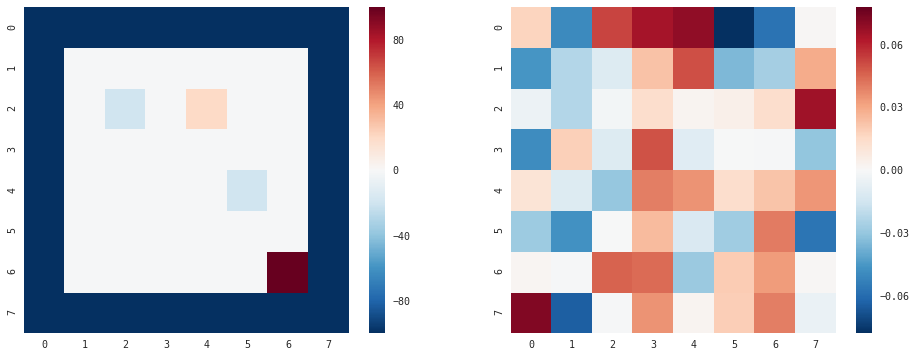

In [23]:
plot_q_values(nrows=reward_matrix.shape[0], ncols = reward_matrix.shape[1], 
              plot_reward=True, save_q_plot=True, t=0, episode=0)

The left hand plot is the reward grid, which looks like what we'd expect. And yup, the right hand plot (Q values) looks pretty random. A little bit [Mondrian](https://www.google.co.uk/search?q=mondrian+paintings&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjP2dPs4NvUAhWDPBQKHXSSAM4Q_AUICigB&biw=2100&bih=1127)?

Anyway, how do we move beyond random Q values? How do we learn useful Q values that can help us navigate a maze? For that, we'll need to do some ***Q learning*** (of [DeepMind Atari fame](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)). There's actually many different varieties of Q-learning, and here we have a special simple case where there are very few, discrete states and actions (this is a tabular method), we aren't doing any feature extraction from the environment (e.g. no [deep convnets for Q learning](https://vmayoral.github.io/robots,/ai,/deep/learning,/rl,/reinforcement/learning/2016/08/07/deep-convolutional-q-learning/)), and we aren't keeping any sort of running memory (e.g. [eligiblity traces](https://mpatacchiola.github.io/blog/2017/01/29/dissecting-reinforcement-learning-3.html)).

### Q function update rule

We will learn the real Q values iteratively using a simple update rule. Basically, to update $Q(s, a)$ at time $t$ (so, $Q(s_t, a_t)$), we will do a one step look ahead and find the maximum Q value you could immediately get from that successor state. In other words we peak ahead one step and find the estimate of the optimal future state. This is $\max_{a} Q(s_{t+1}, a_t)$. We take our previous Q value $Q(s_t, a_t)$ for a state-action pair at time t, and make the following update:

\begin{align*}
    Q(s_t, a_t) = Q(s_t, a_t) + \alpha * (r_{t+1} + \gamma*  max_a Q(s_{t+1}, a_t) -  Q(s_t, a_t))   
\end{align*}

The alpha parameter $\alpha$ controls your learning rate (higher values weight new information higher, overwrites old information more). The gamma parameter $\gamma$ (the 'discount factor') controls how much we prefer recent rewards to far-away rewards - if it's 0, we only ever care about immediate rewards, and if it's 1, we care about very distant rewards exactly as much as recent ones. You can change up alpha and gamma in clever ways as the algorithm trains but we'll just set them to... 0.8.

Actually it's interesting to note that if you set alpha to 1.0 then the update rule becomes very short:

\begin{align*}
    Q(s_t, a_t) = r_{t+1} + \gamma*  max_a Q(s_{t+1}, a_t)    
\end{align*}

This is a recursive definition, since the current Q value depends on the immediate reward plus the discounted maximum future Q value. In this way, the $Q(s,a)$ estimates take into account the Q values of future states. The values will gradually converge after many iterations (often surprisingly few iterations). Information about future rewards eventually trickles back to the value estimates of states at the beginning of the maze - this will become clear through the code examples.

The code for doing one Q update is:

In [25]:
def update_q_value(current_state, next_state, action, alpha, gamma, terminal_state, verbose=False):
    
    # make move and collect reward
    reward = reward_matrix[next_state[0], next_state[1]]
    
    # the current q for the state + action we just took
    current_q = q.loc[((q['str_state']==str(current_state)) & (q['action']==action)), 'value'].values[0]
        
    # get maximum q value leading on from next_state
    max_future_q_value = np.max(q[q['str_state']==str(next_state)]['value'])
    
    # q value update rule
    new_q = current_q + alpha*(reward + gamma*max_future_q_value - current_q)
     
    # update relevant value in q table
    q.loc[((q['str_state']==str(current_state)) & (q['action']==action)), 'value'] = new_q
    
    # if next state is the terminal state, update that q value to reward
    if str(next_state) == str(terminal_state):
        q.loc[(q['str_state']==str(next_state)), 'value'] = 100

    if verbose:
        print 'Q of state {0} taking action "{1}" was updated from {2} to {3}'.format(current_state, action, current_q, new_q)

    return reward

Let's use this function to do a one step update. Remember this is our q table so far:

In [26]:
q.head(10)

,state,str_state,action,value
0,"[0, 0]","[0, 0]",down,0.088719
0,"[0, 0]","[0, 0]",right,-0.053906
1,"[0, 1]","[0, 1]",down,-0.099292
1,"[0, 1]","[0, 1]",left,-0.094281
1,"[0, 1]","[0, 1]",right,0.045629
2,"[0, 2]","[0, 2]",down,0.077985
2,"[0, 2]","[0, 2]",left,-0.001175
2,"[0, 2]","[0, 2]",right,0.081815
3,"[0, 3]","[0, 3]",down,0.024194
3,"[0, 3]","[0, 3]",left,0.094344


What would the q table look like after we do one step to the right, to cell [0,1]? This is actually a lava cell on the grid, so we hope that this would be reflected in the updated value..

In [27]:
update_q_value(current_state=[0,0], next_state=[0,1], action='right', 
               alpha=0.8, gamma=0.8, terminal_state=[6,6], verbose=True)

Q of state [0, 0] taking action "right" was updated from -0.0539056131055 to -79.9815785052


-100.0

This new value replaces the previous `Q(s=[0,0], a='right')` entry in the table. 

We can double check this by hand. Recall that the reward is -100 for being in lava, `alpha` and `gamma` are both 0.8, and the previous estimate of $Q(s,a)$ was -0.0539056131055. 

The only tricky part is that we need to find the highest Q value associated with the successor state. Our starting state was [0,0] and the action we chose (maybe randomly) was 'right', so this means that the successor state is [0,1]. Looks like there are three actions we can take at state [0,1]: down, left, right. Of these, going right has the highest Q value (which is 0.045629). Plugging these values in:

In [28]:
new_q = -0.0539056131055 + 0.8*(-100 + 0.8*0.045629 - -0.0539056131055)
new_q   

-79.98157856262111

Looks good! What if we then went back left? Q table looks like this now:

In [33]:
q.head(10)

,state,str_state,action,value
0,"[0, 0]","[0, 0]",down,0.088719
0,"[0, 0]","[0, 0]",right,-79.981579
1,"[0, 1]","[0, 1]",down,-0.099292
1,"[0, 1]","[0, 1]",left,-0.094281
1,"[0, 1]","[0, 1]",right,0.045629
2,"[0, 2]","[0, 2]",down,0.077985
2,"[0, 2]","[0, 2]",left,-0.001175
2,"[0, 2]","[0, 2]",right,0.081815
3,"[0, 3]","[0, 3]",down,0.024194
3,"[0, 3]","[0, 3]",left,0.094344


We'd expect this change:

In [34]:
new_q = -0.094281 + 0.8*(-100 + 0.8*0.088719 - -0.094281)
new_q   

-79.96207604

Which our function should be able to do:

In [35]:
update_q_value(current_state=[0,1], next_state=[0,0], action='left', 
               alpha=0.8, gamma=0.8, terminal_state=[6,6], verbose=True)

Q of state [0, 1] taking action "left" was updated from -0.0942807842647 to -79.9620758104


-100.0

What would happen to the Q value next to the terminal state, the escape corner at [6,6]? Say we start in state [6, 5] and take a right. Let's pull out the relevant rows of Q values from the table:

In [36]:
q[q['str_state']=='[6, 5]']

,state,str_state,action,value
53,"[6, 5]","[6, 5]",up,-0.029473
53,"[6, 5]","[6, 5]",down,0.007947
53,"[6, 5]","[6, 5]",left,0.063252
53,"[6, 5]","[6, 5]",right,0.037774


In [37]:
update_q_value(current_state=[6,5], next_state=[6,6], action='right', 
               alpha=0.8, gamma=0.8, terminal_state=[6,6], verbose=True)

Q of state [6, 5] taking action "right" was updated from 0.0377742980307 to 80.0664819946


100.0

Success! The fact that there is a big reward at the end of taking the action 'right' from state [6,5] gets reflected in a higher Q(s=[6,5], a='right') value. 

### Learning all the Q values iteratively

The above little tidbits showed the effect of single updates in isolation, but of course we want to do many, many updates during out training episode, until the point that the Q value estimates are stable. Once stability/convergence is reached, the hope is that the new table will accurately represent how good it is to be in any state and take any action in our environment.

Just one more thing to think about before we run the training. It's possible to learn good Q values by randomly walking around the maze (taking actions completely at random) and just observing which rewards come your way. But another approach is to take actions that you think are good, at the same time as you're building your estimates of how good they are. This latter approach is called an ***on-policy*** method - the policy is just telling us how to behave, and the approach is on-policy because our actions are influenced by the Q values we learn about. The random approach is ***off-policy***, because even though we are building Q value estimates of how to behave, we aren't following that advice, and instead are using a totally different, random policy to move around the world. 

So basically, we can learn about the optimal policy while being maximally exploratory. Alternatively, as we gather information, we can let this immediately change how we behave. 

The parameter epsilon ($\epsilon$) controls to what extent our decisions about actions will be random. Do we *always* want to make random decisions about movement (off-policy; set $\epsilon$>1), or only sometimes make random decisions (0<$\epsilon$<1), or whether we'll always go where the utility values look best ($\epsilon$=0). Let's try `epsilon=0.5`, which will lead to random movements 50% of the time, but 50% of the time we choose the best-looking action.

The function to run the entire simulation is this (explanation below):

In [38]:
def learn_maze(reward_matrix, lava_grid=False, alpha=0.8, gamma=0.8, epsilon=0.2, 
               n_episodes=15, t_per_episode=1000, verbose=False, 
               plot_often=False, plot_episode_end=True):

    # initialise q table
    q = initialise_q_table(reward_matrix, use_zero=False)

    # episodes end when terminal state reached (==escaped maze)
    for episode in range(int(n_episodes)):

        print 'Commencing episode number {0}...'.format(episode)
        t = 0
        escaped = False
        
        # begin in the top left corner of the grid (but not in the lava!)
        if lava_grid:
            current_state = [1,1]
            terminal_state = [6,6]        
        else:
            current_state = [0,0]
            terminal_state = [5,5]

        # while you're in the maze, make decisions about actions
        while not escaped and t < t_per_episode:

            # get q table info relating to your current state
            current_state_slice = q[q['str_state'] == str(current_state)]

            # small chance of acting randomly (epsilon)
            if np.random.rand() < epsilon:
                valid_moves = np.array(current_state_slice['action'])
                action = np.random.choice(valid_moves)

            # otherwise, do what looks best
            else:
                'Taking best action'
                best_action_index = np.argmax(np.array(current_state_slice['value']))
                action = np.array(current_state_slice['action'])[best_action_index]           

            next_state = move(current_state, action)

            # get your reward and update your q value
            update_q_value(current_state, next_state, action, alpha=alpha, gamma=gamma, 
                           terminal_state=terminal_state, verbose=verbose)

            # if you reached the terminal state, you win gg
            if str(next_state) == str(terminal_state):
                print 'Escaped maze in {0} time steps.'.format(t)
                escaped = True
                
                if plot_episode_end:
                    plot_q_values(save_q_plot=True, t=t, episode=episode)

            # update current state and time step
            # occasionally plot q values
            if plot_often:
                if t == 0 or t % 500 == 0:
                    print 'Current state at time {0} is: {1}'.format(t, current_state)
                    plot_q_values(save_q_plot=True, t=t, episode=episode)

            t += 1
            current_state = next_state

This function is a bit dense-looking but is actually composed of very simple things:

+ **Line 6**: Initialise the Q values randomly (or to all zeros)
+ **Line 9**: We'll let the worm do many different runs through the maze
+ **Lines 16-21**: Depending on whether you want to run the basic maze or the advanced maze with the lava moat, the starting position and the position (the terminal state) will vary. 
+ **Line 24**: Given that you haven't escaped (reached the terminal state), and your time hasn't run out (arbitrary n), make decisions about where to go next in the grid.
+ **Line 27**: Just taking a slice of the Q table that relates to our current state, for convenience, since we'll be using these values below.
+ **Lines 30 to 32**: Sample a random value between 0 and 1 using np.random.rand(). If this is less than epsilon, choose a random action out of the available ones
+ **Lines 35 to 38**: If the random value wasn't less than epsilon, choose the action associated with the highest utility. 
+ **Line 40**: whichever action you chose, now's the time to get the next state it leads to.
+ **Line 43**: Update your Q value by looking ahead one step from this `next_state` (see previous sections for explanation). 
+ **Lines 47 to 52**: Check if this next state is actually the terminal state. If it is, you reached the end of the maze! Make a self-congratulatory plot of the q table as it stands (if `plot_episode_end==True`) and set `escaped` to `True`.
+ **Lines 56 to 59**: A bit of monitoring code - if you'd like to keep a closer tab on the Q values as they evolve, pass `plot_often=True`. 
+ **Lines 61 and 62**: Incrementing the time step and updating our current state.

Let's run one episode.

Commencing episode number 0...
Escaped maze in 45 time steps.


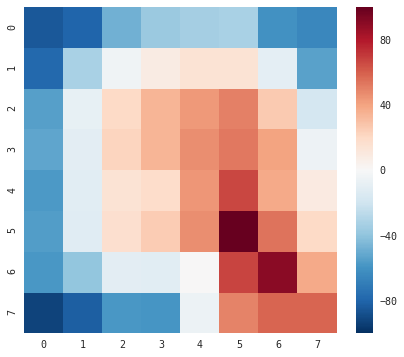

In [46]:
learn_maze(reward_matrix, lava_grid=False, alpha=0.95, gamma=0.8, epsilon=0.5, 
               n_episodes=1, t_per_episode=1000, verbose=False, plot_often=False, plot_episode_end=True)

Let's see that reward grid again?

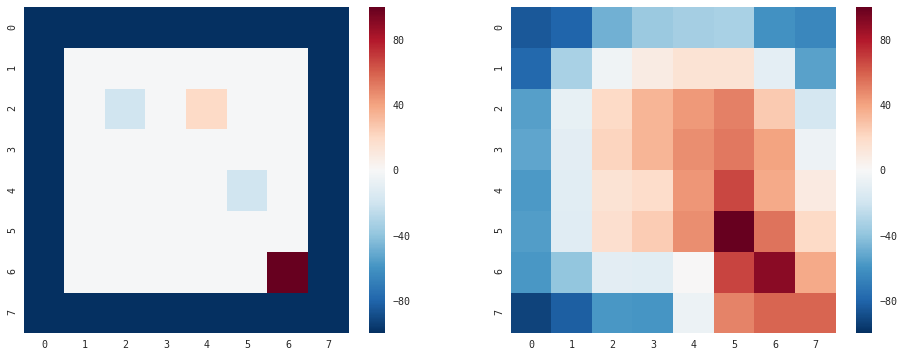

In [47]:
plot_q_values(nrows=reward_matrix.shape[0], ncols = reward_matrix.shape[1], 
              plot_reward=True, save_q_plot=True, t=0, episode=0)

Cool, definitely looks inspired by the reward grid, even after just 1 short episode. Given that we were plonked into this world with absolutely zero knowledge about the world (we could only try things out and get feedback from the environment), we now already know quite a bit. 

### Using Q values to quickly leave the maze

Now that we've gathered lots of information about the Q values (though normally we'd train for much, much longer), traversing the maze again is ez mode. For each state we're in, we are just going to greedily choose the available action with the highest utility, and keep doing that until we escape. 

In [60]:
def traverse_grid(q, lava_grid=False, random_action_prob=0.0, plot_each_step=True):
    
    print 'Traversing maze...'
    
    if lava_grid:
        current_state = [1, 1]
        terminal_state = [6, 6]
    else:
        current_state = [0, 0]
        terminal_state = [5, 5]
    
    t=0
    
    # traverse greedily
    while str(current_state) != str(terminal_state):

        print 'Current state is: {0}'.format(current_state)
        
        if plot_each_step:
            plot_current_position(current_state, t)

        # lookup q values of actions in current states
        current_state_slice = q[q['str_state'] == str(current_state)]
        best_action_index = np.argmax(np.array(current_state_slice['value']))
        action = np.array(current_state_slice['action'])[best_action_index] 
        
        # make a move
        next_state = move(current_state, action)

        # if you won then plot it
        if next_state == terminal_state and plot_each_step==True:
            plot_current_position(next_state, t+1, reached_terminal=True)
            
        current_state = next_state
        t += 1
    
    # when done, make gif of path taken
    make_traversal_gif(t, random_action_prob)

The code for traversing the grid is simple (extremely simlar to `learn_maze` code above) but plotting is a bit of a pain. We will need two helper functions to make nice GIFs to visualise our path in the maze. The `plot_current_position` function takes your current position and plots it on the learned Q values heatmap. The `make_traversal_gif` function uses [imageio](https://imageio.readthedocs.io/en/latest/) magic to spit out a gif (make sure the `image_path` only has .png files that you want included in your GIF... clean out those cat memes). 

In [49]:
def plot_current_position(current_state, t, reward_matrix=reward_matrix, q=q, reached_terminal=False):
    
    # plot heatmap of q values
    nrows=reward_matrix.shape[0]
    ncols=reward_matrix.shape[1]
    avg_q_value_by_state = q.groupby('str_state')['value'].mean().values.reshape(nrows,ncols)
    plt.figure(figsize=(7,6))
    heatmap = sns.heatmap(avg_q_value_by_state)        
    
    # add rectangle for current position
    if not reached_terminal:
        heatmap.add_patch(patches.Rectangle((current_state[0]-0.00, 7-current_state[1]-0.00), 1, 1, 
                                       fill=True, alpha=0.25, linewidth=1))
        heatmap.add_patch(patches.Rectangle((current_state[0]-0.00, 7-current_state[1]-0.00), 1, 1, 
                                       fill=False, color='black', linewidth=5))
    else: 
        heatmap.add_patch(patches.Rectangle((current_state[0]-0.00, 7-current_state[1]-0.00), 1, 1, 
                                       fill=True, alpha=0.25, linewidth=1))
        heatmap.add_patch(patches.Rectangle((current_state[0]-0.00, 7-current_state[1]-0.00), 1, 1, 
                                       fill=False, color='white', linewidth=8))
        
    # save fig
    heatmap.get_figure().savefig('png_for_gif/' + 'traversing_step_' + str(t) + '.png')

In [50]:
def make_traversal_gif(t, random_action_prob, image_path='png_for_gif/*.png', gif_path='png_for_gif/'):
    
    # grab images to GIFify
    images = natsorted(glob.glob(image_path))
    gif_name = gif_path + 'traversal_in_' + str(t) + '_steps_random_p' + str(random_action_prob) + '.gif'

    with imageio.get_writer(gif_name, mode='I',  duration=0.5) as writer:
        for image_name in images:
            image = imageio.imread(image_name)
            writer.append_data(image)

Now we can run this:

In [61]:
traverse_grid(q, lava_grid=True, plot_each_step=False)

Traversing maze...
Current state is: [1, 1]
Current state is: [1, 2]
Current state is: [1, 3]
Current state is: [2, 3]
Current state is: [2, 4]
Current state is: [2, 5]
Current state is: [3, 5]
Current state is: [3, 6]
Current state is: [4, 6]
Current state is: [5, 6]


And get this GIF of our path across the maze out as a result:

<img src="https://raw.githubusercontent.com/jagex-data-science/maze_runner/master/traversal_in_10_steps_random_p0.0.gif")>

### Further work [for me]

1. show results of trianing for much longer 
2. getting agent to pick up treats/avoid trolls (probably jsut need to train longer)
3. Write total reward and time steps on heatmap plots per time step t
4. Embed GIFs properly
5. Do the experiments below? Or maybe this is for another post
6. **** Put physically barriers/walls into maze

## Some experiments

Now that we have all of this code in place it's time to enjoy ourselves by running experiments.

### 1. Many episodes versus one episode

### 2. Cutting episodes short by restricting max $t$

### 3. Changing keeness to update knowledge, gamma

### 4. Changing the learning rate, alpha

### 5. Off-policy completely random walk

### 6. On-policy learning with low epsilon

### 7. On-policy learning with high epsilon

### Further work [for readers]

A lot of improvements could be made to this post but this little project has already opened a time wormhole so I'll cut it there. Some suggestions for taking this further:
    + Better Q value plots - instead of averaged by all directions to get one value per state, represent action-specific utility values with little arrows with variable thickness (like in Richard Sutton's grid world demo at 12:00)
    + See the effects of SARSA update rule instead of Q learning update rule on learning
    + Play around with different starting reward grids/maze configuations
    + Normalisation of Q values by state

If you found this post interesting or find some mistakes (confession: am noob), let me know in the comments below :) 